## Calculate POP2 heat budget using xgcm
Contributed by Anna-Lena Deppenmeier

Using xgcm with metric to demonstrate budget closure. 

This is an image of the POP output structure on the horizontal B-grid courtesy Yassir Eddebbar

<img src="POP_Grid.png" alt="Drawing" style="width: 800px;"/>

### Import packages and define functions

In [18]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from tqdm import tqdm

import pop_tools


def pop_find_lat_ind(loc, LATDAT):
    return np.abs(LATDAT[:, 0].values - loc).argmin()


def pop_find_lon_ind(loc, LONDAT, direction="w"):
    if direction.lower() in ["east", "e"]:
        value = loc
    elif direction.lower() in ["west", "w"]:
        value = 360 - loc
    else:
        print("I do not know which direction.")
    return np.nanargmin(np.abs(LONDAT[152, :].values - value))

### Load Dataset

In [41]:
# open sample data
filepath = pop_tools.DATASETS.fetch("Pac_POP0.1_JRA_IAF_1993-12-6-test.nc")
ds = xr.open_dataset(filepath)

# get DZU and DZT, needed for operations later on
filepath_g = pop_tools.DATASETS.fetch("Pac_grid_pbc_1301x305x62.tx01_62l.2013-07-13.nc")
ds_g = xr.open_dataset(filepath_g)

In [30]:
# get lola inds from somewhere for indexing later on
lola_inds = {}
inds_lat = [-8, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 8]
for j in inds_lat:
    if j < 0:
        lola_inds["j_" + str(j)[1:] + "s"] = pop_find_lat_ind(j, ds_g.TLAT)
    else:
        lola_inds["j_" + str(j) + "n"] = pop_find_lat_ind(j, ds_g.TLAT)

inds_lon = range(95, 185, 5)
for i in inds_lon:
    lola_inds["i_" + str(i) + "_w"] = pop_find_lon_ind(i, ds_g.TLONG)

#### just making sure everything works

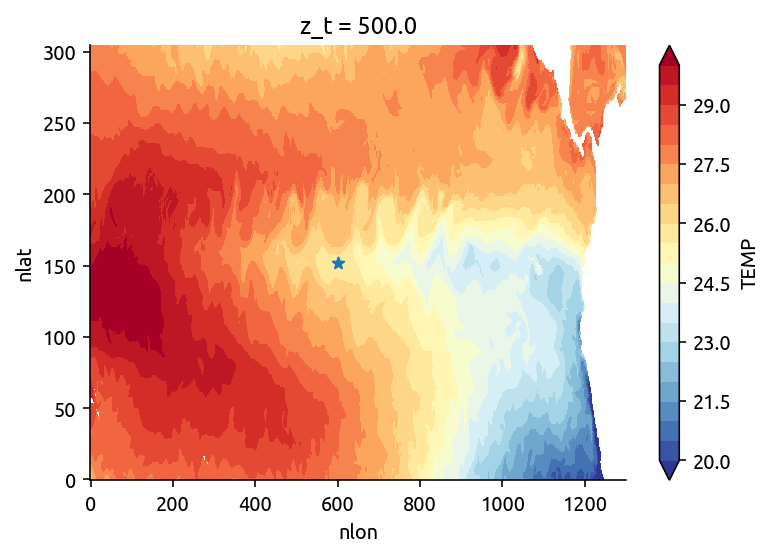

In [31]:
# just making sure everything works
ds.TEMP.isel(z_t=0).mean(dim="time").plot(levels=np.arange(20, 30.5, 0.5), cmap="RdYlBu_r")
plt.scatter(lola_inds["i_140_w"], lola_inds["j_0n"], marker="*")

#### set up vertical thickness and volume for scaling

In [32]:
ds["DZT"] = ds_g.DZT
ds["DZU"] = ds_g.DZU

ds.DZT.attrs["long_name"] = "Thickness of T cells"
ds.DZT.attrs["units"] = "centimeter"
ds.DZT.attrs["grid_loc"] = "3111"
ds.DZU.attrs["long_name"] = "Thickness of U cells"
ds.DZU.attrs["units"] = "centimeter"
ds.DZU.attrs["grid_loc"] = "3221"

# make sure we have the cell volumne for calculations
VOL = (ds.DZT * ds.DXT * ds.DYT).compute()
KMT = ds_g.KMT.compute()

for j in tqdm(range(len(KMT.nlat))):
    for i in range(len(KMT.nlon)):
        k = KMT.values[j, i].astype(int)
        VOL.values[k:, j, i] = 0.0

ds["VOL"] = VOL

ds.VOL.attrs["long_name"] = "volume of T cells"
ds.VOL.attrs["units"] = "centimeter^3"

ds.VOL.attrs["grid_loc"] = "3111"

100%|██████████| 305/305 [00:01<00:00, 208.06it/s]


#### Set up dataset to gather budget terms

In [8]:
budget = xr.Dataset()

#### set grid and data set for xgcm with metrics

In [33]:
metrics = {
    ("X",): ["DXU", "DXT"],  # X distances
    ("Y",): ["DYU", "DYT"],  # Y distances
    ("Z",): ["DZU", "DZT"],  # Z distances
    ("X", "Y"): ["UAREA", "TAREA"],
}

# here we get the xgcm compatible dataset
gridxgcm, dsxgcm = pop_tools.to_xgcm_grid_dataset(
    ds,
    periodic=False,
    metrics=metrics,
    boundary={"X": "extend", "Y": "extend", "Z": "extend"},
)

for coord in ["nlat", "nlon"]:
    if coord in dsxgcm.coords:
        dsxgcm = dsxgcm.drop_vars(coord)

#### 0) Tendency

In [ ]:
budget['TEND_TEMP'] = dsxgcm.TEND_TEMP

#### i) Total heat advection

In [ ]:
budget["UET"] = -(gridxgcm.diff(dsxgcm.UET * dsxgcm.VOL.values, axis="X") / dsxgcm.VOL)
budget["VNT"] = -(gridxgcm.diff(dsxgcm.VNT * dsxgcm.VOL.values, axis="Y") / dsxgcm.VOL)
budget["WTT"] = (
    gridxgcm.diff(dsxgcm.WTT.fillna(0) * (dsxgcm.dz * dsxgcm.DXT * dsxgcm.DYT).values, axis="Z")
    / dsxgcm.VOL
)
budget["TOT_ADV"] = budget["UET"] + budget["VNT"] + budget["WTT"]

#### ii) Heat flux due to vertical mixing:
includes surface flux at the 0th layer

In [18]:
budget["DIA_IMPVF_TEMP"] = -(
    gridxgcm.diff(dsxgcm.DIA_IMPVF_TEMP * dsxgcm.TAREA, axis="Z") / dsxgcm.VOL
)

# set surface flux at 0th layer
SRF_TEMP_FLUX = (dsx.SHF - dsx.SHF_QSW) * dsx.hflux_factor

budget["DIA_IMPVF_TEMP"][:, 0, :, :] = (
    SRF_TEMP_FLUX * dsxgcm.TAREA - dsxgcm.DIA_IMPVF_TEMP.isel(z_w_bot=0) * dsxgcm.TAREA
) / dsxgcm.VOL.values[0, :, :]

budget["KPP_SRC_TMP"] = dsxgcm.KPP_SRC_TEMP
budget["VDIF"] = budget["DIA_IMPVF_TEMP"] + budget["KPP_SRC_TMP"]

#### iii) Heat flux due to horizontal diffusion

In [19]:
budget["HDIFE_TEMP"] = gridxgcm.diff(dsxgcm.HDIFE_TEMP * dsxgcm.VOL.values, axis="X") / dsxgcm.VOL
budget["HDIFN_TEMP"] = gridxgcm.diff(dsxgcm.HDIFN_TEMP * dsxgcm.VOL.values, axis="Y") / dsxgcm.VOL
budget["HDIF"] = budget["HDIFE_TEMP"] + budget["HDIFN_TEMP"]

#### iv) Solar Penetration

In [20]:
budget["QSW_3D"] = -gridxgcm.diff((dsxgcm.QSW_3D * dsxgcm.hflux_factor), axis="Z") / dsxgcm.DZT

#### plot to make sure it closes at (0N, 140W)

In [38]:
subset = budget.isel(nlon_t=lola_inds["i_140_w"], nlat_t=lola_inds["j_0n"], time=0)

AttributeError: 'Dataset' object has no attribute 'VDIF'

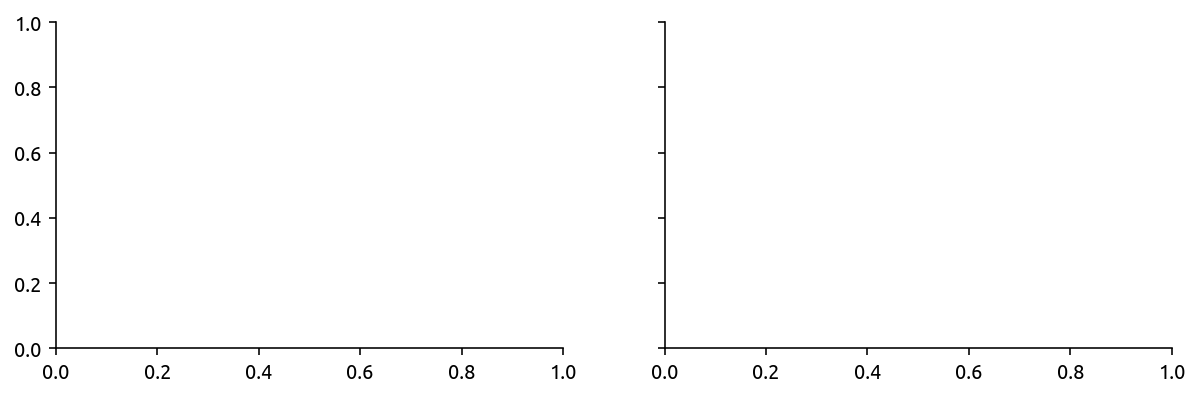

In [40]:
%%time

fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

# plot individual components
subset.VDIF.plot(y="z_t", ylim=(300e2, 0), label="VDIF", ax=ax[0])
subset.HDIF.plot(y="z_t", ylim=(300e2, 0), label="HDIF", ax=ax[0])
subset.QSW_3D.plot(y="z_t", ylim=(300e2, 0), label="QSW_3D", ax=ax[0])
subset.TOT_ADV.plot(y="z_t", ylim=(300e2, 0), label="DIV", ax=ax[0])

# plot sum
(subset.QSW_3D + subset.HDIF + subset.VDIF + subset.TOT_ADV).plot(
    y="z_t", ylim=(300e2, 0), label="SUM", ls="--", ax=ax[0]
)
# plot tendency
subset.TEND_TEMP.plot(y="z_t", ylim=(300e2, 0), label="TEND_TEMP", ax=ax[0])

ax[0].legend()

# plot sum
(subset.QSW_3D + subset.HDIF + subset.VDIF + subset.TOT_ADV).plot(
    y="z_t", ylim=(300e2, 0), label="SUM", ls="--", ax=ax[1]
)
# plot tendency
subset.TEND_TEMP.plot(y="z_t", ylim=(300e2, 0), label="TEND_TEMP", ax=ax[1])

ax[1].legend()

In [25]:
# You may need to install watermark (conda install -c conda-forge watermark)
import xgcm  # just to display the version

%load_ext watermark
%watermark -d -iv -m -g -h
print("Above are the versions of the packages this works with.")

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1127.18.2.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 72
Architecture: 64bit

Hostname: casper12

Git hash: HEAD

ncar_jobqueue: 2020.3.4
dask         : 2021.2.0
numpy        : 1.19.5
xarray       : 0.17.0
distributed  : 2021.2.0
pop_tools    : 2020.9.14
matplotlib   : 3.2.2

Above are the versions of the packages this works with.
